In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import dask.dataframe as dd
import warnings
from asyncio import CancelledError
from dask.delayed import delayed
from dask.distributed import Client
from cycler import cycler
from IPython.display import clear_output

In [2]:
default_colors = ['#00c6ff', '#0078ff', '#dd2a7b']
mpl.rcParams['axes.prop_cycle'] = cycler('color', default_colors)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 18

# pd.set_option('display.max_colwidth', None)

# Methodology

In exploring dataset for this report, the group analyzed a high population density dataset amounting to a total of over 8.12Gb. In order to handle this amount of memory, the group used distributed dask clustering to handle a big amount of data surpassing the capability of the local machine/client's memory. The general workflow for the formation of this report is shown in the figure below.

1. Data Extraction
2. Data Processing
3. Exploratory Data Analysis


<center><strong>Fig.## Methodology </strong></center>

# Data Description

# Data Extraction

## Dask Distributed Cluster

In [13]:
client = Client('172.31.47.101:8786')

In [14]:
client

Client Scheduler: tcp://172.31.47.101:8786 Dashboard: http://172.31.47.101:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.04 GB


In [21]:
def get_path(country):
    """Return country CSV S3 path"""
    return dict(total_pop=('s3://dataforgood-fb-data/csv/month=2019-06'
                           f'/country={country}/type=total_population'
                           f'/{country}_total_population.csv.gz'),
                child=('s3://dataforgood-fb-data/csv/month=2019-06'
                             f'/country={country}/type=children_under_five'
                             f'/{country}_children_under_five.csv.gz'),
                elder=('s3://dataforgood-fb-data/csv/month=2019-06'
                               f'/country={country}/type=elderly_60_plus'
                               f'/{country}_elderly_60_plus.csv.gz'),
                men=('s3://dataforgood-fb-data/csv/month=2019-06'
                     f'/country={country}/type=men'
                     f'/{country}_men.csv.gz'),
                women=('s3://dataforgood-fb-data/csv/month=2019-06'
                       f'/country={country}/type=women'
                       f'/{country}_women.csv.gz'),
                reprod=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}'
                        '/type=women_of_reproductive_age_15_49'
                        f'/{country}_women_of_'
                        'reproductive_age_15_49.csv.gz'),
                youth=('s3://dataforgood-fb-data/csv/month=2019-06'
                        f'/country={country}/type=youth_15_24'
                        f'/{country}_youth_15_24.csv.gz')
            )

In [16]:
# List of countries to analyze
countries = ['DEU',
             'GBR',
             'FRA',
             'ITA',
             'ESP',
             'PRT',
             'CHE',
             'GRC',
             'NLD',
             'POL',
             'BEL',
             'AUT',
             'ISL',
             'HRV',
             'CZE',
             'ROU',
             'UKR',
             'HUN',
             'ALB',
             'SVK',
             'MNE',
             'MDA',
             'SRB',
             'BLR']

In [17]:
df_countries_child = dict()
df_countries_youth = dict()
df_countries_elder = dict()

## Child

In [50]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_child = [delayed(pd.read_csv)(get_path(country)['child'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_child = dd.from_delayed(dfs_child)
    except CancelledError:
        df_child = dd.from_delayed(dfs_child)
        
    print('Repartition {}'.format(country))
    df_child = df_child.repartition(npartitions=100)
    df_countries_child[country] = df_child
    del dfs_child
    del df_child
clear_output()
print('Done')

Done


## Youth

In [30]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_youth = [delayed(pd.read_csv)(get_path(country)['youth'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_youth = dd.from_delayed(dfs_youth)
    except CancelledError:
        df_youth = dd.from_delayed(dfs_youth)
        
    print('Repartition {}'.format(country))
    df_youth = df_youth.repartition(npartitions=100)
    df_countries_youth[country] = df_youth
    del dfs_youth
    del df_youth
clear_output()
print('Done')

Done


## Elder

In [32]:
for country in countries:
    print('Extracting data from {}'.format(country))
    dfs_elder = [delayed(pd.read_csv)(get_path(country)['elder'],
                                     encoding='utf-8', sep='\t',
                                     compression='gzip')]
    print('Converting to DataFrame {}'.format(country))
    
    try:
        df_elder = dd.from_delayed(dfs_elder)
    except CancelledError:
        df_elder = dd.from_delayed(dfs_elder)
        
    print('Repartition {}'.format(country))
    df_elder = df_elder.repartition(npartitions=100)
    df_countries_elder[country] = df_elder
    del dfs_elder
    del df_elder
clear_output()
print('Done')

Done


# Data Preprocessing

Merge all the datasets per category to compare different countries. We added a new column country and people count to determine the total number of people per 30 sqm and identify which country the row belonged.

In [84]:
def add_features(df, country):
    """Return dataframe with required column columns"""
    df = df.copy()
    df['country'] = country
    # Population density with 30 sqm
    df['people_count'] = df['population'].apply(lambda x: int(x*30),
                                                meta=('population', 'int64'))
    return df

## Child

In [85]:
df_child = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_child.items()],
                     axis=0)

In [86]:
df_child.count().compute()

latitude        229182034
longitude       229182034
population      229182034
country         229182034
people_count    229182034
dtype: int64

## Youth

In [87]:
df_youth = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_youth.items()],
                     axis=0)

In [88]:
df_youth.count().compute()

latitude        229182034
longitude       229182034
population      229182034
country         229182034
people_count    229182034
dtype: int64

## Elder

In [89]:
df_elder = dd.concat([add_features(ddf, country)
                      for country, ddf in df_countries_elder.items()],
                     axis=0)

In [90]:
df_elder.count().compute()

latitude        229182034
longitude       229182034
population      229182034
country         229182034
people_count    229182034
dtype: int64

# Exploratory Data Analysis

## Child

In [103]:
total_pop = df_child.groupby(['country']).people_count.sum().compute()
total_pop.sort_values(inplace=True)

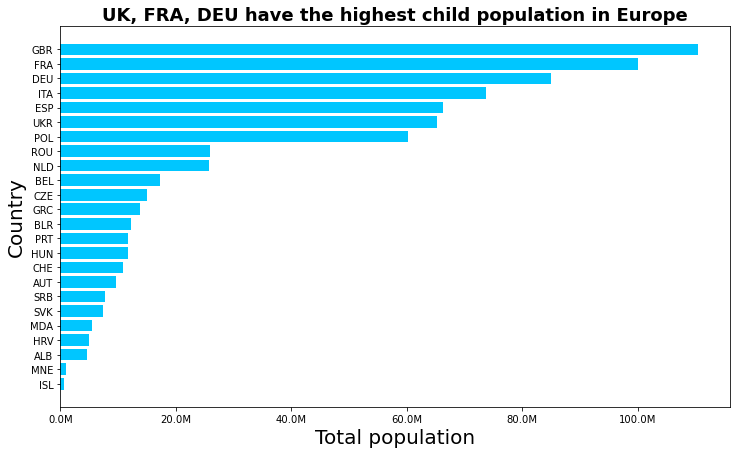

In [141]:
plt.figure(figsize=(12, 7))
y = total_pop.index
x = total_pop.values
# Plot data
plt.barh(y, x)
plt.title('UK, FRA, DEU have the highest child population in Europe')
plt.ylabel('Country')
plt.xlabel('Total population')

# Change ticks
ax = plt.gca()
xlabels = [f'{x:.1f}M' for x in ax.get_xticks()/1e6]
ax.set_xticklabels(xlabels)
plt.show()
warnings.filterwarnings('ignore')

## Youth

In [ ]:
total_pop = df_youth.groupby(['country']).people_count.sum().compute()
total_pop.sort_values(inplace=True)

In [ ]:
plt.figure(figsize=(12, 7))
y = total_pop.index
x = total_pop.values
# Plot data
plt.barh(y, x)
# plt.title('UK, FRA, DEU have the highest youth population(15 to 24 yrs.) in Europe')
plt.ylabel('Country')
plt.xlabel('Total population')

# Change ticks
ax = plt.gca()
xlabels = [f'{x:.1f}M' for x in ax.get_xticks()/1e6]
ax.set_xticklabels(xlabels)
plt.show()
warnings.filterwarnings('ignore')